In [28]:
import os
from os.path import join
import glob

import nibabel as nib
import dicom
import numpy as np

%matplotlib inline

### Load an example slice

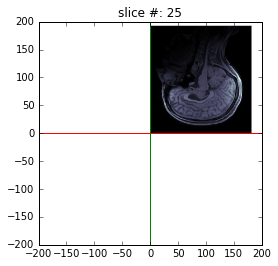

In [53]:
# load a slice near the middle of the volume, just for visualizaing
sliceNum = 25
slice_fname = glob.glob('data/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.{:04}.*'.format(sliceNum))
dcm = dicom.read_file(slice_fname[0])

plt.title('slice #: {}'.format(dcm.InstanceNumber))
plt.imshow(dcm.pixel_array, cmap='bone')
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='green')

In [30]:
from mpl_toolkits.mplot3d import Axes3D

In [51]:
pix_rot = np.rot90(dcm.pixel_array)

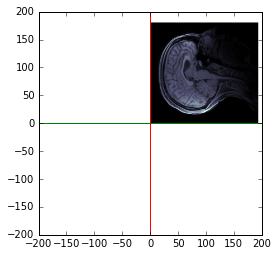

In [52]:
plt.imshow(pix_rot, cmap='bone')
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.axhline(y=0, color='green')
plt.axvline(x=0, color='red')

### start building the affine

In [6]:
# start with an identity matrix. Subsequent steps will overwrite values in the matrix
affine = np.eye(4)
affine

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [8]:
np.set_printoptions(precision=3, suppress=True)

# extract the reformat the ImageOrientationPatient Info
iop = dcm.ImageOrientationPatient
print('ImageOrientationPatient:')
print(iop, end='\n\n')

# reshape the image orientation patient
iop = np.array(iop).reshape(3,2, order='F')
print('orig -----')
print(iop, end='\n\n')


ImageOrientationPatient:
['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']

orig -----
[[ 0.056  0.04 ]
 [ 0.998 -0.002]
 [ 0.    -0.999]]



This is pretty close to an affine matrix that looks like:

In [10]:
np.matrix([[0,0],
         [1,0],
         [0,-1]])


array([[ 0,  0],
       [ 1,  0],
       [ 0, -1]])

This means that the x axis goes from (1,0,0) to (0,1,0) -- i.e. gets rotated into the y-axis

and the y axis goes from (0,1,0) to (0,0,-1) -- i.e. gets rotated into the negative z-axis

## Basic Matrix operations

In [38]:
# matrix to take LPS+ space to RAS+
aff_lps2ras = np.matrix([[-1,0,0,],
                         [0,-1,0],
                         [0,0,1]])

aff_lps2ras

matrix([[-1,  0,  0],
        [ 0, -1,  0],
        [ 0,  0,  1]])

In [39]:
# to take a sagital slice to LPS:
aff_s2lps = np.matrix([[0,0,1],
                       [1,0,0],
                       [0,-1,0]])
aff_s2lps

matrix([[ 0,  0,  1],
        [ 1,  0,  0],
        [ 0, -1,  0]])

Working it out by hand, it seems like the matrix to take that same sagittal slice to RAS+ would be: 

In [42]:
aff_s2ras = np.matrix([[0,0,-1],
                       [-1,0,0],
                       [0,-1,0]])
aff_s2ras

matrix([[ 0,  0, -1],
        [-1,  0,  0],
        [ 0, -1,  0]])

The question is whether multiplying `aff_s2lps` by `aff_lps2ras` will produce the same thing as `aff_s2ras`

In [46]:
test_aff = aff_s2lps + aff_lps2ras
test_aff

matrix([[-1,  0,  1],
        [ 1, -1,  0],
        [ 0, -1,  1]])

In [45]:
test2 = aff_lps2ras * aff_s2lps
test2

matrix([[ 0,  0, -1],
        [-1,  0,  0],
        [ 0, -1,  0]])